### Results For paper

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [4]:
import sys
sys.path.append('../..')
sys.path.append('../modules')

import warnings
def warn(message, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.style.use('seaborn-paper')
from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import lifelines
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts, rmst_plot
from lifelines.utils import restricted_mean_survival_time

from diabetes_onset_plotter import survival_fit_res, make_results

In [5]:
np.random.seed(seed = 0)

### Load Data

In [7]:
s3_path = 'nneehal/DATA/odata/m6_propens_no_cluster_only_latent'
data_path = '../temp'

!aws s3 cp s3://cdphp-s3-us-e-p-pond/rpi/{s3_path} {data_path} --recursive;

In [8]:
%%time
p = '../temp/'
treated = pd.read_pickle(p+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
controls = pd.read_pickle(p+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

treated['Treatment'] = 1
controls['Treatment'] = 0

CPU times: user 266 ms, sys: 113 ms, total: 378 ms
Wall time: 399 ms


In [5]:
### Optional(filter registrations after  a particular month and before a particular month)

In [9]:
def setfirst(group):
    group['First'] = group.MYR.iloc[0]
    return group

FILTER = False
if FILTER:
    treated = treated.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)
    controls = controls.groupby('PERS_ID').apply(lambda x: setfirst(x)).reset_index(drop = True)

    month_filter_lower = 201711
    month_filter_upper = 202008
    myr_filt = (treated.First <= month_filter_upper) & (treated.First >= month_filter_lower)
    treated = treated[myr_filt].reset_index(drop = True)

    myr_filt = (controls.First <= month_filter_upper) & (controls.First >= month_filter_lower)
    controls = controls[myr_filt].reset_index(drop = True)


### Set common variables

In [10]:
filter_cols =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO',  'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E']

log_normalize = ['ALLOW_AMT']
normalize = ['AGE_AT_MIDMONTH', 'CC_DX_CNT']
#normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']

model_type = 'kaplan'
model = KaplanMeierFitter
model_argsK = {}#{'timeline':24}# {"penalizer":0.001, 'alpha': 0.05}
model_args= {}
fit_args = {"step_size": 0.1, "show_progress":False}

timeline = 24
fit_args1 = {"timeline":np.arange(timeline)}


kaplan_plot_params = {"show_censors": False, "ci_alpha":0.1, "ci_force_lines":False}# "at_risk_counts": False}

In [11]:
path_tabs = '../res/tabs/'
path_figs = '../res/figs/'
path_figs2 = '../res/figs2' #plots without risk at count

#create paths if not created
from pathlib import Path
p1 = Path(path_tabs)
p2 = Path(path_figs)
p3 = Path(path_figs2)

p1.mkdir(parents = True, exist_ok = True)
p2.mkdir(parents = True, exist_ok = True)
p3.mkdir(parents = True, exist_ok = True)

In [12]:
filter_cols2 =  ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT','CC_TOBACCO', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT','LOB', 'T', 'E', 'Treatment']

summary_names =  ['Age','Gender', 'Total Cost',  'Tobacco use',  'Obesity', 
            'Hypertension', 'Hypothyroid', 'Disease Count',  'Line of Bussiness', 'Treatment']

In [21]:
treated = treated.rename(columns={"MEDICAID_LOB":"LOB"})
controls = controls.rename(columns={"MEDICAID_LOB":"LOB"})

### Diabetes

In [25]:
%%time
survTr = treated.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)
survCo = controls.copy().groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)


CPU times: user 13.7 s, sys: 30.4 ms, total: 13.7 s
Wall time: 13.7 s


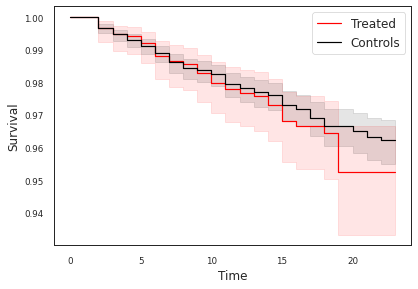

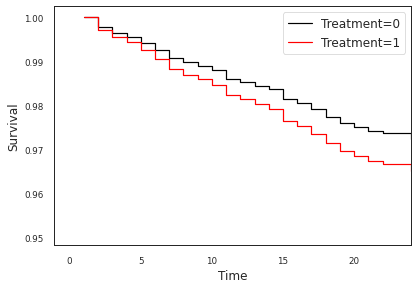

In [26]:
fitted, rmstD = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Diabetes'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize, 
                                      kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [27]:
lrsumm

test_statistic        p  -log2(p)
Diabetes        0.435463  0.50932  0.973355

In [28]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                      2.673           0.533        5.014    0.000
Gender                   0.424           0.144        2.945    0.003
Total Cost               0.157           0.097        1.626    0.104
Tobacco use              0.061           0.273        0.225    0.822
Obesity                  0.373           0.150        2.487    0.013
Hypertension             0.095           0.171        0.560    0.576
Hypothyroid             -0.172           0.258       -0.665    0.506
Disease Count           -0.095           0.626       -0.152    0.879
Line of Bussiness       -0.379           0.239       -1.582    0.114
Treatment                0.240           0.176        1.363    0.173

### ER

In [29]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['ER-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [30]:
%%time
onset = 'ER-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.8 s, sys: 35.2 ms, total: 13.9 s
Wall time: 13.9 s


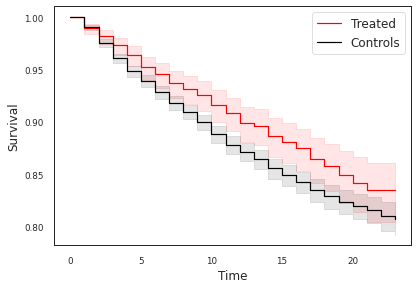

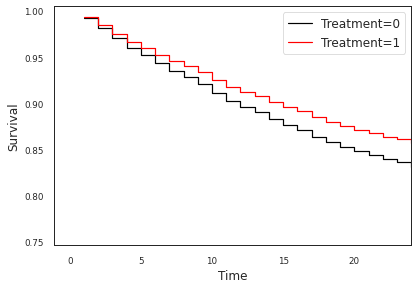

In [31]:
fitted, rmstER = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'ER'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names, 
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [32]:
lrsumm

test_statistic         p  -log2(p)
ER        7.676744  0.005594  7.481981

In [33]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.457           0.216       -6.753    0.000
Gender                  -0.205           0.071       -2.898    0.004
Total Cost               0.154           0.044        3.503    0.000
Tobacco use              0.300           0.097        3.079    0.002
Obesity                 -0.078           0.067       -1.170    0.242
Hypertension             0.120           0.081        1.488    0.137
Hypothyroid             -0.045           0.108       -0.422    0.673
Disease Count            2.167           0.254        8.529    0.000
Line of Bussiness       -0.770           0.079       -9.756    0.000
Treatment               -0.181           0.085       -2.116    0.034

### IP

In [34]:
data = [treated.copy(),  controls.copy()]
for d in data:
    d['IP-bin'] = (d['ALLOW_IP'] > 0).astype(int)

In [35]:
%%time
onset = 'IP-bin'

survTr = data[0].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = data[1].groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.8 s, sys: 20.3 ms, total: 13.8 s
Wall time: 13.8 s


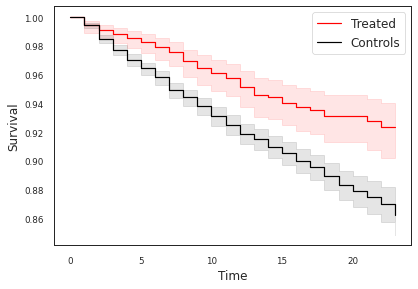

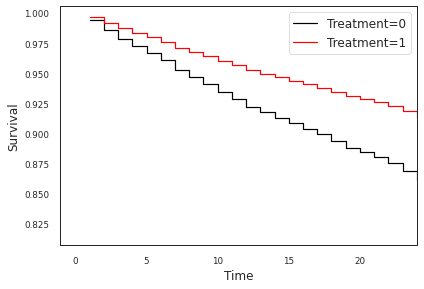

In [36]:
fitted, rmstIP = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type =model_type,
                          model_args = model_argsK,fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'IP'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                     timeline = timeline)

In [37]:
ax1.collections[0].set

<bound method Artist.set of <matplotlib.collections.PolyCollection object at 0x7ff0b94a9080>>

In [38]:
lrsumm

test_statistic         p   -log2(p)
IP       20.600684  0.000006  17.431381

In [39]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -0.543           0.273       -1.989    0.047
Gender                  -0.271           0.090       -3.016    0.003
Total Cost               0.352           0.062        5.709    0.000
Tobacco use              0.117           0.125        0.933    0.351
Obesity                 -0.230           0.084       -2.753    0.006
Hypertension             0.171           0.098        1.743    0.081
Hypothyroid             -0.360           0.138       -2.612    0.009
Disease Count            2.894           0.289       10.021    0.000
Line of Bussiness       -0.393           0.109       -3.611    0.000
Treatment               -0.505           0.119       -4.253    0.000

### Acute Care IP OR ER

In [40]:
data = [treated,  controls]
for d in data:
    d['Acute-bin'] = ((d['ALLOW_ER'] > 0) | (d['ALLOW_IP'] > 0)).astype(int)

In [41]:
%%time
onset = 'Acute-bin'

survTr = treated.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)
survCo = controls.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)


CPU times: user 13.7 s, sys: 32.6 ms, total: 13.7 s
Wall time: 13.7 s


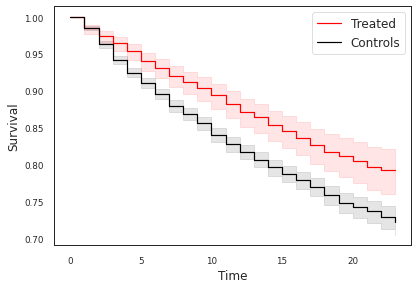

In [42]:
fitted, rmstAcute = survival_fit_res( ['Treated', 'Controls'],  survTr, survCo,
                          model = model, model_type = model_type,
                          model_args = model_argsK, fit_args = fit_args1, filter_cols = filter_cols,
                         log_normalize = log_normalize, normalize = normalize)

outcome = 'Acute'
lrsumm, ax1, ax2, summ = make_results(fitted, survTr, survCo, path_tabs = path_tabs, 
                                      path_figs=path_figs, surv_model = CoxPHFitter,
                                      model_args = model_args, fit_args = fit_args, outcome = outcome, 
                                      filter_cols = filter_cols2, summary_names = summary_names,
                                     log_normalize = log_normalize, normalize = normalize,
                                     kaplan_plot_params=kaplan_plot_params,
                                      timeline = timeline)

In [43]:
lrsumm

test_statistic         p   -log2(p)
Acute       22.258145  0.000002  18.678514

In [44]:
summ

Coefficient  Standard Error  z-statistic  p-value
Age                     -1.077           0.182       -5.935    0.000
Gender                  -0.242           0.060       -4.042    0.000
Total Cost               0.215           0.038        5.634    0.000
Tobacco use              0.206           0.085        2.419    0.016
Obesity                 -0.107           0.056       -1.890    0.059
Hypertension             0.125           0.067        1.860    0.063
Hypothyroid             -0.173           0.092       -1.886    0.059
Disease Count            2.490           0.211       11.780    0.000
Line of Bussiness       -0.655           0.069       -9.496    0.000
Treatment               -0.320           0.074       -4.304    0.000

### Load all Log Rank Sums in a matrix

In [45]:
from pathlib import Path
p = Path('../res/tabs')

df2 = None
for i, ff in enumerate(p.iterdir()):
    if ff.is_file() and ('lgrank' in ff.name):
        if i == 0:
            df2 = pd.read_csv(ff)
        else:
            df2 = pd.concat((df2, pd.read_csv(ff)), axis = 0, ignore_index = False)



df2.set_index(keys =['Unnamed: 0'] , inplace = True)
df2.index.name = ''
df2.columns = ['logRank statistic', 'p-value','a']
df2.drop(columns= ['a'], inplace = True)
df2.index = ['Diabetes', 'Emergency Visits', 'Inpatient Vistis', 'Acute Care']
df2['RMST difference'] = np.array([rmstD, rmstER, rmstIP, rmstAcute])
df2.round(3).to_csv('../res/tabs/all_logrank.csv')


In [46]:
df2

logRank statistic   p-value  RMST difference
Diabetes                   0.435463  0.509320        -0.079240
Emergency Visits           7.676744  0.005594         0.523490
Inpatient Vistis          20.600684  0.000006         0.731310
Acute Care                22.258145  0.000002         1.087955